In [1]:
import torch
print(torch.__version__)
import torchvision

2.1.0+cu121


In [2]:
model = torchvision.models.resnet50()
model = torch.compile(model)

If compatibility score for your GPU is at least 8.0, it can use most of the improvements brought by pytorch 2.0

In [3]:
# Make sure we're using a NVIDIA GPU
if torch.cuda.is_available():
  gpu_info = !nvidia-smi
  gpu_info = '\n'.join(gpu_info)
  if gpu_info.find("failed") >= 0:
    print("Not connected to a GPU, to leverage the best of PyTorch 2.0, you should connect to a GPU.")

  # Get GPU name
  gpu_name = !nvidia-smi --query-gpu=gpu_name --format=csv
  gpu_name = gpu_name[1]
  GPU_NAME = gpu_name.replace(" ", "_") # remove underscores for easier saving
  print(f'GPU name: {GPU_NAME}')

  # Get GPU capability score
  GPU_SCORE = torch.cuda.get_device_capability()
  print(f"GPU capability score: {GPU_SCORE}")
  if GPU_SCORE >= (8, 0):
    print(f"GPU score higher than or equal to (8, 0), PyTorch 2.x speedup features available.")
  else:
    print(f"GPU score lower than (8, 0), PyTorch 2.x speedup features will be limited (PyTorch 2.x speedups happen most on newer GPUs).")

  # Print GPU info
  print(f"GPU information:\n{gpu_info}")

else:
  print("PyTorch couldn't find a GPU, to leverage the best of PyTorch 2.0, you should connect to a GPU.")

GPU name: Tesla_T4
GPU capability score: (7, 5)
GPU score lower than (8, 0), PyTorch 2.x speedup features will be limited (PyTorch 2.x speedups happen most on newer GPUs).
GPU information:
Tue Jan  9 08:00:13 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8              10W /  70W |      3MiB / 153

## Setting device globally

In [4]:
### setting device globally
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# # A. context manager version
# with torch.device(device): # creating context manager to get rid of necessity for model.to(device) and etc
#     layer = torch.nn.Linear(20, 30)
#     print(f"A. Device: {layer.weight.device}")

# B. global version
# torch.set_default_device(device)
layer = torch.nn.Linear(20, 30)
print(f"B. Device: {layer.weight.device}")

B. Device: cpu


## Speed test experiments

### Creating Model

In [5]:
def create_model(num_classes=10):
    weights = torchvision.models.ResNet50_Weights.DEFAULT
    transforms = weights.transforms()

    model = torchvision.models.resnet50(weights)
    model.fc = torch.nn.Linear(in_features=2048, out_features=num_classes)
    return model, transforms

model, transforms = create_model()
model, transforms

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


(ResNet(
   (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (layer1): Sequential(
     (0): Bottleneck(
       (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (downsample): Sequential(
         (0): Conv2d(64, 256, kernel_size=(1,

### Leveraging speedups

In [6]:
total_free_gpu_memory, total_gpu_memory = torch.cuda.mem_get_info()
total_free_memory_gb = round(total_free_gpu_memory * 1e-9, 3)
# if free memory is > 16GB, set batch_size=128, else set batch_size=32
if total_free_memory_gb>=16:
    BATCH_SIZE = 128
    IMAGE_SIZE = 224
    print(f"Available GPU memory: {total_free_memory_gb} GB, using batch_size: {BATCH_SIZE}, using image size: {IMAGE_SIZE}")
else:
    BATCH_SIZE = 32
    IMAGE_SIZE = 128
    print(f"Available GPU memory: {total_free_memory_gb} GB, using batch_size: {BATCH_SIZE}, using image size: {IMAGE_SIZE}")

transforms.crop_size = IMAGE_SIZE
transforms.resize_size = IMAGE_SIZE
print(f"Updated data transforms: \n{transforms}")

Available GPU memory: 15.728 GB, using batch_size: 32, using image size: 128
Updated data transforms: 
ImageClassification(
    crop_size=128
    resize_size=128
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [7]:
# TensorFloat32 - datatype by NVIDIA, combining float32 and float16, uses float32 when precision is important, else uses float16 if speed is important. Available on Ampere + GPUs
if GPU_SCORE >= (8, 0): # check if our gpu is compatible with TensorFloat32
    print("Enabling TensorFloat32")
    torch.backends.cuda.matmul.allow_tf32 = True
else:
    print("GPU is not compatible with TensorFloat32")
    torch.backends.cuda.matmul.allow_tf32 = False

GPU is not compatible with TensorFloat32


### Getting data ready

In [11]:
import os
from torch.utils.data import DataLoader
NUM_WORKERS = os.cpu_count()

train_dataset = torchvision.datasets.CIFAR10(root='.',
                                             train=True,
                                             transform=transforms,
                                             download=True)
test_dataset = torchvision.datasets.CIFAR10(root='.',
                                             train=False,
                                             transform=transforms,
                                             download=True)

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS,
                            #   generator=torch.Generator(device=device) # or shuffle=False to solve cpu type generator error
                              ) # a rule is: 4*number_of_gpus

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NUM_WORKERS
                             ) # a rule is: 4*number_of_gpus
len(train_dataloader), len(test_dataloader)

Files already downloaded and verified
Files already downloaded and verified


(1563, 313)

In [13]:
import time
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(epoch: int,
               model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device,
               disable_progress_bar: bool = False) -> Tuple[float, float]:
  """Trains a PyTorch model for a single epoch.

  Turns a target PyTorch model to training mode and then
  runs through all of the required training steps (forward
  pass, loss calculation, optimizer step).

  Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
  """
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  progress_bar = tqdm(
        enumerate(dataloader),
        desc=f"Training Epoch {epoch}",
        total=len(dataloader),
        disable=disable_progress_bar
    )

  for batch, (X, y) in progress_bar:
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item()

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

      # Update progress bar
      progress_bar.set_postfix(
            {
                "train_loss": train_loss / (batch + 1),
                "train_acc": train_acc / (batch + 1),
            }
        )


  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def test_step(epoch: int,
              model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device,
              disable_progress_bar: bool = False) -> Tuple[float, float]:
  """Tests a PyTorch model for a single epoch.

  Turns a target PyTorch model to "eval" mode and then performs
  a forward pass on a testing dataset.

  Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
  """
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Loop through data loader data batches
  progress_bar = tqdm(
      enumerate(dataloader),
      desc=f"Testing Epoch {epoch}",
      total=len(dataloader),
      disable=disable_progress_bar
  )

  # Turn on inference context manager
  with torch.no_grad(): # no_grad() required for PyTorch 2.0, I found some errors with `torch.inference_mode()`, please let me know if this is not the case
      # Loop through DataLoader batches
      for batch, (X, y) in progress_bar:
          # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

          # Update progress bar
          progress_bar.set_postfix(
              {
                  "test_loss": test_loss / (batch + 1),
                  "test_acc": test_acc / (batch + 1),
              }
          )

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          disable_progress_bar: bool = False) -> Dict[str, List]:
  """Trains and tests a PyTorch model.

  Passes a target PyTorch models through train_step() and test_step()
  functions for a number of epochs, training and testing the model
  in the same epoch loop.

  Calculates, prints and stores evaluation metrics throughout.

  Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
                  train_acc: [...],
                  test_loss: [...],
                  test_acc: [...]}
    For example if training for epochs=2:
                 {train_loss: [2.0616, 1.0537],
                  train_acc: [0.3945, 0.3945],
                  test_loss: [1.2641, 1.5706],
                  test_acc: [0.3400, 0.2973]}
  """
  # Create empty results dictionary
  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": [],
      "train_epoch_time": [],
      "test_epoch_time": []
  }

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs), disable=disable_progress_bar):

      # Perform training step and time it
      train_epoch_start_time = time.time()
      train_loss, train_acc = train_step(epoch=epoch,
                                        model=model,
                                        dataloader=train_dataloader,
                                        loss_fn=loss_fn,
                                        optimizer=optimizer,
                                        device=device,
                                        disable_progress_bar=disable_progress_bar)
      train_epoch_end_time = time.time()
      train_epoch_time = train_epoch_end_time - train_epoch_start_time

      # Perform testing step and time it
      test_epoch_start_time = time.time()
      test_loss, test_acc = test_step(epoch=epoch,
                                      model=model,
                                      dataloader=test_dataloader,
                                      loss_fn=loss_fn,
                                      device=device,
                                      disable_progress_bar=disable_progress_bar)
      test_epoch_end_time = time.time()
      test_epoch_time = test_epoch_end_time - test_epoch_start_time

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f} | "
          f"train_epoch_time: {train_epoch_time:.4f} | "
          f"test_epoch_time: {test_epoch_time:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)
      results["train_epoch_time"].append(train_epoch_time)
      results["test_epoch_time"].append(test_epoch_time)

  # Return the filled results at the end of the epochs
  return results

### Experiment 1: no torch.compile(), single run

In [14]:
epochs = 5
lr = 0.003

model, _ = create_model()
model.to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
exp1_results = train(model=model,
                     train_dataloader=train_dataloader,
                     test_dataloader=test_dataloader,
                     loss_fn=loss_fn,
                     optimizer=optimizer,
                     epochs=epochs,
                     device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0:   0%|          | 0/1563 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bed0ae87400>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1409, in _shutdown_workers
    if not self._shutdown:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_shutdown'


Testing Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bed0ae87400>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1409, in _shutdown_workers
    if not self._shutdown:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_shutdown'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bed0ae87400>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1409, in _shutdown_workers
    if not self._shutdown:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_shutdown'


Epoch: 1 | train_loss: 1.1296 | train_acc: 0.5976 | test_loss: 0.8349 | test_acc: 0.7131 | train_epoch_time: 197.5567 | test_epoch_time: 16.9746


Training Epoch 1:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 0.6845 | train_acc: 0.7623 | test_loss: 0.6926 | test_acc: 0.7701 | train_epoch_time: 200.9606 | test_epoch_time: 16.0191


Training Epoch 2:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.5182 | train_acc: 0.8214 | test_loss: 0.5397 | test_acc: 0.8195 | train_epoch_time: 196.7118 | test_epoch_time: 15.9814


Training Epoch 3:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 0.4122 | train_acc: 0.8573 | test_loss: 0.4968 | test_acc: 0.8367 | train_epoch_time: 197.0168 | test_epoch_time: 17.2914


Training Epoch 4:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 0.3242 | train_acc: 0.8873 | test_loss: 0.4678 | test_acc: 0.8492 | train_epoch_time: 201.2136 | test_epoch_time: 16.1133


### Experiment 2: with Pytorch.compile(), single run

In [19]:
epochs = 5
lr = 0.003

model, _ = create_model()
model.to(device)
import time
start = time.time()
compiled_model = torch.compile(model)
compiled_model.to(device)
end = time.time()
print(f"Compiling took: {end-start}s")

import torch._dynamo
torch._dynamo.config.suppress_errors = True

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
exp2_results = train(model=compiled_model,
                     train_dataloader=train_dataloader,
                     test_dataloader=test_dataloader,
                     loss_fn=loss_fn,
                     optimizer=optimizer,
                     epochs=epochs,
                     device=device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


Compiling took: 0.002853870391845703s


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0:   0%|          | 0/1563 [00:00<?, ?it/s]

[2024-01-09 09:16:24,407] torch._dynamo.convert_frame: [WARNING] WON'T CONVERT forward /usr/local/lib/python3.10/dist-packages/torchvision/models/resnet.py line 284 
[2024-01-09 09:16:24,407] torch._dynamo.convert_frame: [WARNING] due to: 
[2024-01-09 09:16:24,407] torch._dynamo.convert_frame: [WARNING] Traceback (most recent call last):
[2024-01-09 09:16:24,407] torch._dynamo.convert_frame: [WARNING]   File "/usr/lib/python3.10/concurrent/futures/process.py", line 720, in submit
[2024-01-09 09:16:24,407] torch._dynamo.convert_frame: [WARNING]     raise BrokenProcessPool(self._broken)
[2024-01-09 09:16:24,407] torch._dynamo.convert_frame: [WARNING] torch._dynamo.exc.BackendCompilerFailed: backend='inductor' raised:
[2024-01-09 09:16:24,407] torch._dynamo.convert_frame: [WARNING] BrokenProcessPool: A child process terminated abruptly, the process pool is not usable anymore
[2024-01-09 09:16:24,407] torch._dynamo.convert_frame: [WARNING] 
[2024-01-09 09:16:24,407] torch._dynamo.convert_f

Testing Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1355 | train_acc: 0.5947 | test_loss: 0.8464 | test_acc: 0.7076 | train_epoch_time: 256.5687 | test_epoch_time: 16.9480


Training Epoch 1:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 0.7057 | train_acc: 0.7545 | test_loss: 0.6104 | test_acc: 0.7874 | train_epoch_time: 211.0632 | test_epoch_time: 21.7275


Training Epoch 2:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.5293 | train_acc: 0.8174 | test_loss: 0.5638 | test_acc: 0.8091 | train_epoch_time: 205.8278 | test_epoch_time: 22.0172


Training Epoch 3:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 0.4178 | train_acc: 0.8546 | test_loss: 0.4987 | test_acc: 0.8317 | train_epoch_time: 215.4907 | test_epoch_time: 16.6049


Training Epoch 4:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 0.3250 | train_acc: 0.8866 | test_loss: 0.4843 | test_acc: 0.8399 | train_epoch_time: 198.3270 | test_epoch_time: 17.1213


In [20]:
# comparing experiment1 and experiment 2 results
import pandas as pd
exp_1_df = pd.DataFrame(exp1_results)
exp_2_df = pd.DataFrame(exp2_results)

In [22]:
DATASET_NAME = 'Cifar10'
MODEL_NAME = 'ResNet50'

import matplotlib.pyplot as plt
import numpy as np

def plot_mean_epoch_times(non_compiled_results: pd.DataFrame,
                          compiled_results: pd.DataFrame,
                          multi_runs: bool=False,
                          num_runs: int=0,
                          save: bool=False,
                          save_path: str="",
                          dataset_name: str=DATASET_NAME,
                          model_name: str=MODEL_NAME,
                          num_epochs: int=epochs,
                          image_size: int=IMAGE_SIZE,
                          batch_size: int=BATCH_SIZE) -> plt.figure:

    # Get the mean epoch times from the non-compiled models
    mean_train_epoch_time = non_compiled_results.train_epoch_time.mean()
    mean_test_epoch_time = non_compiled_results.test_epoch_time.mean()
    mean_results = [mean_train_epoch_time, mean_test_epoch_time]

    # Get the mean epoch times from the compiled models
    mean_compile_train_epoch_time = compiled_results.train_epoch_time.mean()
    mean_compile_test_epoch_time = compiled_results.test_epoch_time.mean()
    mean_compile_results = [mean_compile_train_epoch_time, mean_compile_test_epoch_time]

    # Calculate the percentage difference between the mean compile and non-compile train epoch times
    train_epoch_time_diff = mean_compile_train_epoch_time - mean_train_epoch_time
    train_epoch_time_diff_percent = (train_epoch_time_diff / mean_train_epoch_time) * 100

    # Calculate the percentage difference between the mean compile and non-compile test epoch times
    test_epoch_time_diff = mean_compile_test_epoch_time - mean_test_epoch_time
    test_epoch_time_diff_percent = (test_epoch_time_diff / mean_test_epoch_time) * 100

    # Print the mean difference percentages
    print(f"Mean train epoch time difference: {round(train_epoch_time_diff_percent, 3)}% (negative means faster)")
    print(f"Mean test epoch time difference: {round(test_epoch_time_diff_percent, 3)}% (negative means faster)")

    # Create a bar plot of the mean train and test epoch time for both compiled and non-compiled models
    plt.figure(figsize=(10, 7))
    width = 0.3
    x_indicies = np.arange(len(mean_results))

    plt.bar(x=x_indicies, height=mean_results, width=width, label="non_compiled_results")
    plt.bar(x=x_indicies + width, height=mean_compile_results, width=width, label="compiled_results")
    plt.xticks(x_indicies + width / 2, ("Train Epoch", "Test Epoch"))
    plt.ylabel("Mean epoch time (seconds, lower is better)")

    # Create the title based on the parameters passed to the function
    if multi_runs:
        plt.suptitle("Multiple run results")
        plt.title(f"GPU: {gpu_name} | Epochs: {num_epochs} ({num_runs} runs) | Data: {dataset_name} | Model: {model_name} | Image size: {image_size} | Batch size: {batch_size}")
    else:
        plt.suptitle("Single run results")
        plt.title(f"GPU: {gpu_name} | Epochs: {num_epochs} | Data: {dataset_name} | Model: {model_name} | Image size: {image_size} | Batch size: {batch_size}")
    plt.legend();

    # Save the figure
    if save:
        assert save_path != "", "Please specify a save path to save the model figure to via the save_path parameter."
        plt.savefig(save_path)
        print(f"[INFO] Plot saved to {save_path}")

Mean train epoch time difference: 9.444% (negative means faster)
Mean test epoch time difference: 14.614% (negative means faster)
[INFO] Plot saved to pytorch_2_results/figs/single_run_Tesla_T4_ResNet50.png


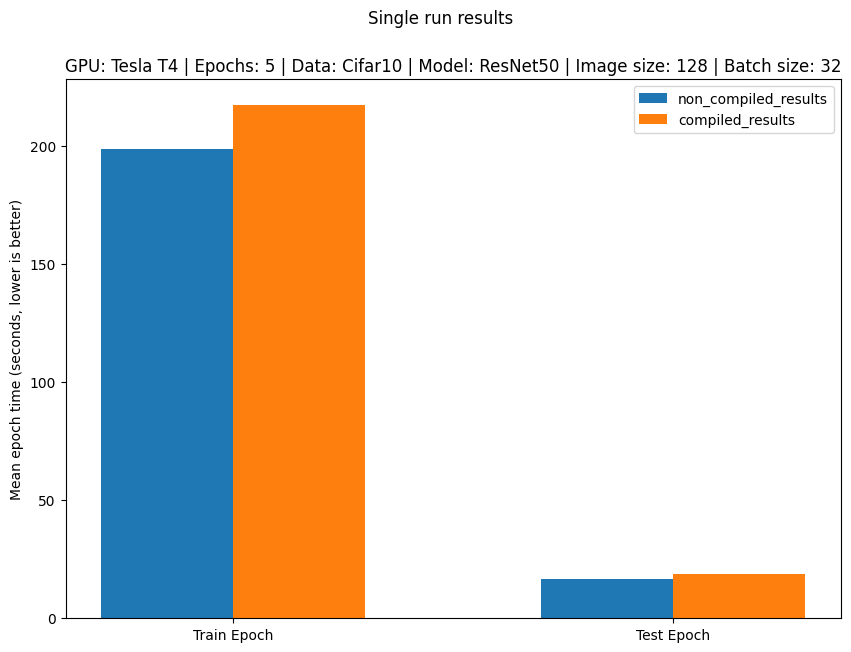

In [23]:
import os
dir_to_fig = 'pytorch_2_results/figs/'
os.makedirs(dir_to_fig, exist_ok=True)

save_path_single_run = f"{dir_to_fig}single_run_{GPU_NAME}_{MODEL_NAME}.png"
plot_mean_epoch_times(exp_1_df, exp_2_df, multi_runs=False, save_path=save_path_single_run, save=True)

In [24]:
# Make a directory for single_run results
import os
pytorch_2_results_dir = "pytorch_2_results"
pytorch_2_single_run_results_dir = f"{pytorch_2_results_dir}/single_run_results"
os.makedirs(pytorch_2_single_run_results_dir, exist_ok=True)

# Create filenames for each of the dataframes
save_name_for_non_compiled_results = f"single_run_non_compiled_results_{DATASET_NAME}_{MODEL_NAME}_{GPU_NAME}.csv"
save_name_for_compiled_results = f"single_run_compiled_results_{DATASET_NAME}_{MODEL_NAME}_{GPU_NAME}.csv"

# Create filepaths to save the results to
single_run_no_compile_save_path = f"{pytorch_2_single_run_results_dir}/{save_name_for_non_compiled_results}"
single_run_compile_save_path = f"{pytorch_2_single_run_results_dir}/{save_name_for_compiled_results}"
print(f"[INFO] Saving non-compiled experiment 1 results to: {single_run_no_compile_save_path}")
print(f"[INFO] Saving compiled experiment 2 results to: {single_run_compile_save_path}")

# Save the results
exp_1_df.to_csv(single_run_no_compile_save_path)
exp_2_df.to_csv(single_run_compile_save_path)

[INFO] Saving non-compiled experiment 1 results to: pytorch_2_results/single_run_results/single_run_non_compiled_results_Cifar10_ResNet50_Tesla_T4.csv
[INFO] Saving compiled experiment 2 results to: pytorch_2_results/single_run_results/single_run_compiled_results_Cifar10_ResNet50_Tesla_T4.csv


### Experiment 3: no torch.compile(), multiple run

In [26]:
def create_and_train_non_compiled_model(epochs=epochs,
                                        learning_rate=lr,
                                        disable_progress_bar=False):
    """
    Create and train a non-compiled PyTorch model.
    """
    model, _ = create_model()
    model.to(device)

    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate)

    results = train(model=model,
                    train_dataloader=train_dataloader,
                    test_dataloader=test_dataloader,
                    loss_fn=loss_fn,
                    optimizer=optimizer,
                    epochs=epochs,
                    device=device,
                    disable_progress_bar=disable_progress_bar)
    return results

def create_compiled_model():
    """
    Create a compiled PyTorch model and return it.
    """
    model, _ = create_model()
    model.to(device)

    compile_start_time = time.time()
    ### New in PyTorch 2.x ###
    compiled_model = torch.compile(model)
    ##########################
    compile_end_time = time.time()

    compile_time = compile_end_time - compile_start_time

    print(f"Time to compile: {compile_time} | Note: The first time you compile your model, the first few epochs will be slower than subsequent runs.")
    return compiled_model

def train_compiled_model(model=compiled_model,
                         epochs=epochs,
                         learning_rate=lr,
                         disable_progress_bar=False):
    """
    Train a compiled model and return the results.
    """
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(compiled_model.parameters(),
                                 lr=learning_rate)

    compile_results = train(model=model,
                            train_dataloader=train_dataloader,
                            test_dataloader=test_dataloader,
                            loss_fn=loss_fn,
                            optimizer=optimizer,
                            epochs=epochs,
                            device=device,
                            disable_progress_bar=disable_progress_bar)

    return compile_results

In [ ]:
num_runs = 3
num_epochs = 5

exp3_results = []
for i in tqdm(range(num_runs)):
    print(f"Run{i+1} for non-compiled model")
    results = create_and_train_non_compiled_model(num_epochs, disable_progress_bar=True)
    exp3_results.append(results)

  0%|          | 0/3 [00:00<?, ?it/s]

Run1 for non-compiled model


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


Epoch: 1 | train_loss: 1.0729 | train_acc: 0.6195 | test_loss: 0.7973 | test_acc: 0.7213 | train_epoch_time: 193.5859 | test_epoch_time: 15.2598


In [ ]:
exp3_df = []
for result in exp3_results:
    df = pd.DataFrame(result)
    exp3_df.append(df)
exp3_dfs = pd.concat(exp3_df)
exp3_df = exp3_df.groupby(exp3_df.index).mean()

### Experiment 4: with torch.compile(), multiple runs

In [ ]:
# Create compiled model
compiled_model = create_compiled_model()

# Create an empty list to store compiled model results
compiled_results_multiple_runs = []

# Run compiled model for multiple runs
for i in tqdm(range(NUM_RUNS)):
    print(f"[INFO] Run {i+1} of {NUM_RUNS} for compiled model")
    # Train the compiled model (note: the model will only be compiled once and then re-used for subsequent runs)
    results = train_compiled_model(model=compiled_model, epochs=NUM_EPOCHS, disable_progress_bar=True)
    compiled_results_multiple_runs.append(results)

In [ ]:
# Go through compile_results_multiple_runs and create a dataframe for each run then concatenate them together
compile_results_dfs = []
for result in compiled_results_multiple_runs:
    result_df = pd.DataFrame(result)
    compile_results_dfs.append(result_df)
compile_results_multiple_runs_df = pd.concat(compile_results_dfs)

# Get the averages across the multiple runs
compile_results_multiple_runs_df = compile_results_multiple_runs_df.groupby(compile_results_multiple_runs_df.index).mean() # .index = groupby the epoch number
compile_results_multiple_runs_df

In [ ]:
# Create a directory to save the multi-run figure to
os.makedirs("pytorch_2_results/figures", exist_ok=True)

# Create a path to save the figure for multiple runs
save_path_multi_run = f"pytorch_2_results/figures/multi_run_{GPU_NAME}_{MODEL_NAME}_{DATASET_NAME}_{IMAGE_SIZE}_train_epoch_time.png"

# Plot the mean epoch times for experiment 3 and 4
plot_mean_epoch_times(non_compiled_results=non_compile_results_multiple_runs_df,
                      compiled_results=compile_results_multiple_runs_df,
                      multi_runs=True,
                      num_runs=NUM_RUNS,
                      save_path=save_path_multi_run,
                      save=True)

In [ ]:
# Make a directory for multi_run results
import os
pytorch_2_results_dir = "pytorch_2_results"
pytorch_2_multi_run_results_dir = f"{pytorch_2_results_dir}/multi_run_results"
os.makedirs(pytorch_2_multi_run_results_dir, exist_ok=True)

# Create filenames for each of the dataframes
save_name_for_multi_run_non_compiled_results = f"multi_run_non_compiled_results_{NUM_RUNS}_runs_{DATASET_NAME}_{MODEL_NAME}_{GPU_NAME}.csv"
save_name_for_multi_run_compiled_results = f"multi_run_compiled_results_{NUM_RUNS}_runs_{DATASET_NAME}_{MODEL_NAME}_{GPU_NAME}.csv"

# Create filepaths to save the results to
multi_run_no_compile_save_path = f"{pytorch_2_multi_run_results_dir}/{save_name_for_non_compiled_results}"
multi_run_compile_save_path = f"{pytorch_2_multi_run_results_dir}/{save_name_for_compiled_results}"
print(f"[INFO] Saving experiment 3 non-compiled results to: {multi_run_no_compile_save_path}")
print(f"[INFO] Saving experiment 4 compiled results to: {multi_run_compile_save_path}")

# Save the results
non_compile_results_multiple_runs_df.to_csv(multi_run_no_compile_save_path)
compile_results_multiple_runs_df.to_csv(multi_run_compile_save_path)